In [1]:
# Necessary when connecting to a jupyterhub kernel running on daint via VScode. NOT required otherwise

import os

new_path = '/users/ajayaraj/scratch/tests/qtpyt-tests/AuBDA13/struct1'
os.chdir(new_path)


In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from gpaw import restart
from gpaw.lcao.pwf2 import LCAOwrap
from gpaw.lcao.tools import remove_pbc
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms, cutcoupling
from ase.io import read
from qtpyt.basis import Basis
from qtpyt.block_tridiag import graph_partition, greenfunction
from qtpyt.surface.principallayer import PrincipalSelfEnergy
from qtpyt.surface.tools import prepare_leads_matrices
from qtpyt.tools import remove_pbc, rotate_couplings
from copy import deepcopy


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Helper functions

In [3]:
def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)


### Control parameters

In [4]:
GPWDEVICEDIR = 'dft/device/'
BRIDGE_SPECIES = ("N", "C", "H")
GPWLEADSDIR = 'dft/leads/'

In [5]:
cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)

In [6]:
lowdin = True
cc_path = Path(GPWDEVICEDIR)
pl_path = Path(GPWLEADSDIR)
gpwfile = f'{cc_path}/scatt.gpw'

atoms, calc = restart(gpwfile, txt=None)
fermi = calc.get_fermi_level()
nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

lcao = LCAOwrap(calc)
H_lcao = lcao.get_hamiltonian()
S_lcao = lcao.get_overlap()
H_lcao -= fermi * S_lcao


Condition number: 2.7e+04


In [7]:
bridge_indices = get_species_indices(atoms, BRIDGE_SPECIES)
basis_bridge = basis[bridge_indices]
bridge_orbital_indices = basis_bridge.get_indices()
bridge_start = bridge_orbital_indices[0]
bridge_end = bridge_orbital_indices[-1]

In [8]:
H_leads_lcao, S_leads_lcao = np.load(pl_path / 'hs_pl_k.npy')

basis_dict = {'Au': 9, 'H': 5, 'C': 13, 'N': 13}

leads_atoms = read(pl_path / 'leads.xyz')
leads_basis = Basis.from_dictionary(leads_atoms, basis_dict)

device_atoms = read(cc_path / 'scatt.xyz')
device_basis = Basis.from_dictionary(device_atoms, basis_dict)


### Correct Nodes obtained from Hamiltonian that Subdiagonalizes C, N and H

In [9]:
# Perform subdiagonalization
SUBDIAG_SPECIES_TO_GET_NODES = ("C", "N", "H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES_TO_GET_NODES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate matrices
H_sub = rotate_matrix(H_lcao, Usub)[None, ...]
S_sub = rotate_matrix(S_lcao, Usub)[None, ...]

# Define the number of repetitions (Nr) and unit cell repetition in the leads
Nr = (1, 5, 3)

# Remove periodic boundary conditions (PBC) from the device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_sub)
remove_pbc(device_basis, S_sub)

# Partition the device Hamiltonian matrix into tridiagonal nodes
nodes = graph_partition.get_tridiagonal_nodes(device_basis, H_sub[0], len(leads_atoms.repeat(Nr)))
print(nodes)

[0, 810, 1116, 1260, 1566, 2376]


### Cut coupling where only C 2 pz is included in the active space

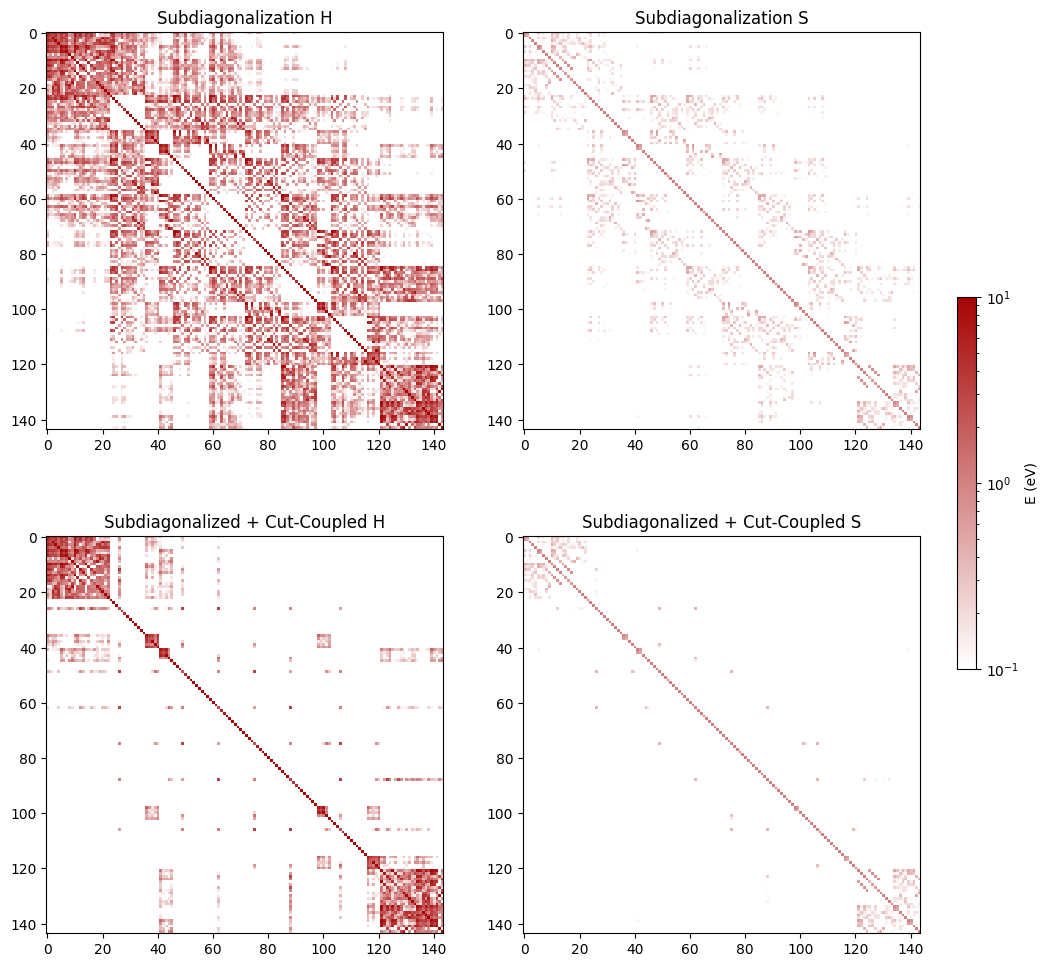

In [10]:
# Define species for subdiagonalization and get their indices in the atom basis
SUBDIAG_SPECIES = ("C")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

# Perform subdiagonalization on the Hamiltonian and overlap matrices
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate the matrices using the subdiagonalization matrix
H_sub = rotate_matrix(H_lcao, Usub)[None, ...]
S_sub = rotate_matrix(S_lcao, Usub)[None, ...]

# Create deep copies of the subdiagonalized matrices for further modification
H_cutcoupled = deepcopy(H_sub)
S_cutcoupled = deepcopy(S_sub)

# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

# Define the active region within the subdiagonalized species
active = {'C': 3}#, 'N': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]

# Determine the indices of the inactive region (outside the active set)
active_set = set(index_active_region)
index_inactive_region = [idx for idx in index_subdiag_region if idx not in active_set]
index_inactive_region = list(index_inactive_region)

# Cut the couplings in the inactive region
cutcoupling(H_cutcoupled[0], S_cutcoupled[0], index_inactive_region)

# Extract the bridge region from the cut-coupled Hamiltonian and overlap matrices
bridge_region_H_cut = H_cutcoupled[0, bridge_start:bridge_end+1, bridge_start:bridge_end+1]
bridge_region_S_cut = S_cutcoupled[0, bridge_start:bridge_end+1, bridge_start:bridge_end+1]

# Remove periodic boundary conditions (PBC) from the cut-coupled device matrices
remove_pbc(device_basis, H_cutcoupled)
remove_pbc(device_basis, S_cutcoupled)


bridge_region_H_sub = H_sub[0, bridge_start:bridge_end+1, bridge_start:bridge_end+1]
bridge_region_S_sub = S_sub[0, bridge_start:bridge_end+1, bridge_start:bridge_end+1]

# Create a figure with a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot the subdiagonalized H matrix for the bridge region
cax1 = axes[0, 0].imshow(np.abs(bridge_region_H_sub), interpolation='nearest', cmap=cm, norm=norm)
axes[0, 0].set_title("Subdiagonalization H")

# Plot the subdiagonalized S matrix for the bridge region
cax2 = axes[0, 1].imshow(np.abs(bridge_region_S_sub), interpolation='nearest', cmap=cm, norm=norm)
axes[0, 1].set_title("Subdiagonalization S")

# Plot the subdiagonalized + cut-coupled Hamiltonian for the bridge region
cax3 = axes[1, 0].imshow(np.abs(bridge_region_H_cut), interpolation='nearest', cmap=cm, norm=norm)
axes[1, 0].set_title("Subdiagonalized + Cut-Coupled H")

# Plot the subdiagonalized + cut-coupled overlap matrix for the bridge region
cax4 = axes[1, 1].imshow(np.abs(bridge_region_S_cut), interpolation='nearest', cmap=cm, norm=norm)
axes[1, 1].set_title("Subdiagonalized + Cut-Coupled S")

# Add a shared colorbar for all subplots
cbar = fig.colorbar(cax4, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('E (eV)')

# Display the combined plots
plt.show()